In [90]:
%pylab inline
import gc
import galsim
import numpy as np
import fpfsBase
import astropy.io.fits as pyfits

import fpfsBase

pltDir='plot/selBias/'
def measure(galImgAll,C):
    imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in range(ngal)]
    a=fpTask.measure(imgList)
    b=fpfsBase.fpfsM2E(a,C)
    del imgList,a
    gc.collect()
    return b

def main(elli0,slow=0.,shigh=1.1,correct=True):
    dss=0.005
    elli=elli0.copy()
    mask=(elli['fpfs_s0']>slow)&(elli['fpfs_s0']<shigh)
    elli=elli[mask]
    mask2=(elli0['fpfs_s0']>slow-dss)&(elli0['fpfs_s0']<=slow+dss)
    RS2=-np.sqrt(2.)*np.sum((1-elli0[mask2]['fpfs_s0'])*elli0[mask2]['fpfs_e1']**2./2./dss)
    mask3=(elli0['fpfs_s0']>shigh-dss)&(elli0['fpfs_s0']<=shigh+dss)
    RS3=np.sqrt(2.)*np.sum((1-elli0[mask3]['fpfs_s0'])*elli0[mask3]['fpfs_e1']**2./2./dss)
    if correct:
        RS=RS2+RS3
    else:
        RS=0.
    g1=np.sum(elli['fpfs_e1'])/(np.sum(elli['fpfs_RE'])+RS)
    del mask,elli,mask2,RS
    gc.collect()
    return g1

Populating the interactive namespace from numpy and matplotlib


In [43]:
cd wrkDir/FPFS2/sim

[Errno 2] No such file or directory: 'wrkDir/FPFS2/sim'
/lustre/work/xiangchong.li/work/FPFS2/sim


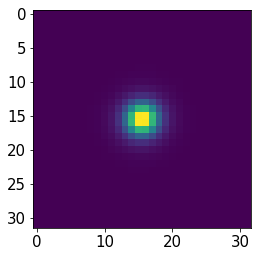

In [37]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
scale=0.168
beta=0.75
psfFWHM=0.60
rcut=16
beg=ngrid//2-rcut
end=beg+2*rcut
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
plt.imshow(psfData)
fpTask=fpfsBase.fpfsTask(psfData,beta=beta)

0.015667978413789606


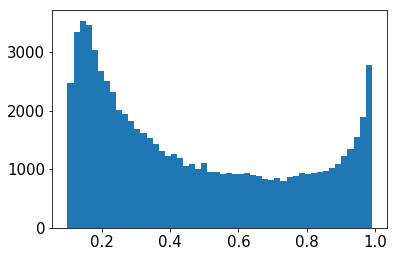

In [77]:
C=1000.
import numpy.lib.recfunctions as rfn

elli1=[]
elli2=[]
for ifield in range(8):
    # read galaxy image
    galImgAll1=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-2222.fits' %(psfFWHM*100,ifield))
    galImgAll2=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-0000.fits' %(psfFWHM*100,ifield))
    elli1U=measure(galImgAll1,C)
    elli2U=measure(galImgAll2,C)
    elli1.append(elli1U)
    elli2.append(elli2U)
    del elli1U,elli2U,galImgAll1,galImgAll2
    gc.collect()
elli1=rfn.stack_arrays(elli1,usemask=False)
elli2=rfn.stack_arrays(elli2,usemask=False)
plt.hist(elli1['fpfs_s0'],bins=50,range=(0.1,0.99))
print(elli1['fpfs_s0'].min())

(array([5.000e+00, 2.061e+03, 7.610e+03, 9.264e+03, 6.921e+03, 5.221e+03,
        4.264e+03, 3.523e+03, 3.063e+03, 2.745e+03, 2.303e+03, 2.115e+03,
        1.877e+03, 1.897e+03, 1.752e+03, 1.568e+03, 1.530e+03, 1.494e+03,
        1.460e+03, 1.338e+03, 1.393e+03, 1.434e+03, 1.480e+03, 1.508e+03,
        1.542e+03, 1.480e+03, 1.448e+03, 1.370e+03, 1.267e+03, 1.264e+03,
        1.100e+03, 9.990e+02, 7.580e+02, 5.080e+02, 2.880e+02, 1.320e+02,
        1.800e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([-2.000e-02,  2.000e-04,  2.040e-02,  4.060e-02,  6.080e-02,
         8.100e-02,  1.012e-01,  1.214e-01,  1.416e-01,  1.618e-01,
         1.820e-01,  2.022e-01,  2.224e-01,  2.426e-01,  2.628e-01,
         2.830e-01,  3.032e-01,  3.234e-01,  3.436e-01,  3.638e-01,
         3.840e-01,  4.042e-01,  4.244e-01,  4.446e-01,  4.648e-01,
         4.850e-01,  5.052e-01,  5.2

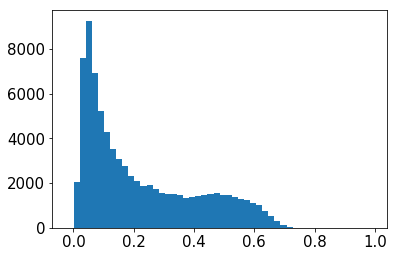

In [78]:
plt.hist(elli1['fpfs_RE'],bins=50,range=(-0.02,0.99))

[-0.0009465  -0.00241851  0.00032995  0.00013998 -0.00065358]


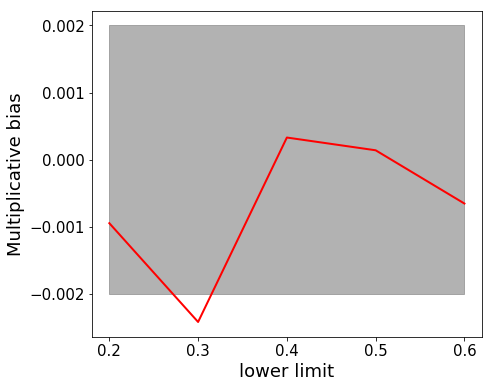

In [91]:
gest=[]
slowList=np.linspace(0.2,0.6,5)
corr=True

for slow in slowList:
    g1p=main(elli1,slow,1.1,corr)
    g1m=main(elli2,slow,1.1,corr)
    gest.append(g1m-g1p)
    gc.collect
gest=np.array(gest)/0.04-1
print(gest)

plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.plot(slowList,gest*1e,c='red',markersize=10)

ax.set_xlabel(r'$s$ (lower limit)')
ax.set_ylabel(r'Multiplicative bias [$\times 10^{-3}$]')
ax.fill_between(slowList,-2*np.ones(len(slowList)),2*np.ones(len(slowList)),color='gray',alpha=0.6)
fig.savefig(os.path.join(pltDir,'selBias_wonoise_low.png'))
fig.savefig(os.path.join(pltDir,'selBias_wonoise_low.pdf'))

[-0.00053709 -0.00082755  0.00409359 -0.00071894 -0.00109803]


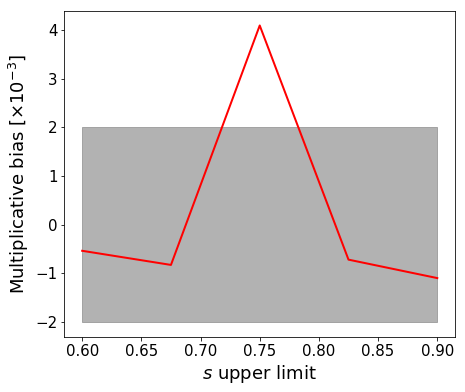

In [95]:
gest=[]
shighList=np.linspace(0.6,0.9,5)
for shigh in shighList:
    g1p=main(elli1,0.,shigh,corr)
    g1m=main(elli2,0.,shigh,corr)
    gest.append(g1m-g1p)
    gc.collect
gest=np.array(gest)/0.04-1
print(gest)
    
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.plot(shighList,gest*1e3,c='red',markersize=10)

ax.set_xlabel(r'$s$ upper limit')
ax.set_ylabel(r'Multiplicative bias [$\times 10^{-3}$]')
ax.fill_between(shighList,-2*np.ones(len(slowList)),2*np.ones(len(slowList)),color='gray',alpha=0.6)
fig.savefig(os.path.join(pltDir,'selBias_wonoise_high.png'))
fig.savefig(os.path.join(pltDir,'selBias_wonoise_high.pdf'))